# Gaussian Covariance Computation

## Goal
The goal of this notebook is to compute the Gaussian covariance for a set of full-sky angulart power spectra and contrast that with the DICES covariance implemented in `heracles`.
Moreover, this tutorial also shows the user how to provide external healpy maps with the neccesary metadata to be processed by `heracles`.


## Dependencies

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import heracles
import heracles.healpy
import heracles.dices as dices

In [2]:
# Set basic parameters
nside = 1024
lmax = int(1.5 * nside)
nlbins = 20

## Generate Theory Angular Power Spectra

In order to generate a theory expectation will simply assume a power law spectrum with a given amplitude and spectral index. This is not the most realistic model, but it will suffice for this example.


In [3]:
ell = np.arange(lmax + 1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2
fl = -np.sqrt((ell + 2) * (ell + 1) * ell * (ell - 1))
fl /= np.clip(ell * (ell + 1), 1, None)

In [4]:
A = 1e-4
cl = A / (2 * ell + 1) ** 2
cl_pp = cl
cl_pe = cl * fl
cl_ee = cl * fl**2
cl_pb = np.zeros_like(cl_pe)
cl_bb = np.zeros_like(cl_ee)
cl_eb = np.zeros_like(cl_ee)
cl_be = np.zeros_like(cl_ee)

# Wrap into heracles.Result objects
# Here axis denotes axis represents what
# index in the array is the ell axis
theory = {}
key = ("POS", "POS", 1, 1)
cl = np.array(cl_pp)
theory[key] = heracles.Result(cl, axis=(0,), ell=ell)

key = ("POS", "SHE", 1, 1)
cl = np.array([cl_pe, cl_pb])
theory[key] = heracles.Result(cl, axis=(1,), ell=ell)

key = ("SHE", "SHE", 1, 1)
cl = np.array(
    [
        [cl_ee, cl_eb],
        [cl_be, cl_bb],
    ]
)
theory[key] = heracles.Result(cl, axis=(2,), ell=ell)

## Simulate Gaussian fields

We will use healpy to generate Gaussian fields with the theory spectra we just generated.

In [5]:
data_maps = hp.sphtfunc.synfast([cl_pp, cl_ee, cl_bb, cl_pe], nside, new=True)
map_t = data_maps[0]
map_q = data_maps[1]
map_u = -data_maps[2]

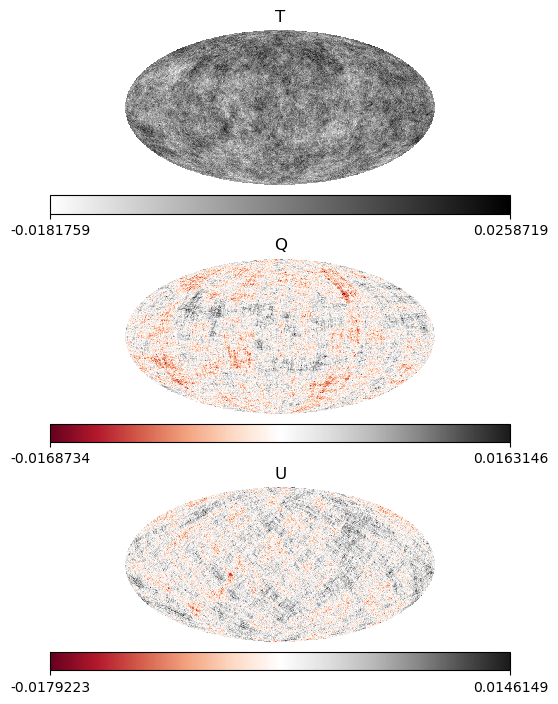

In [6]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(map_t, cmap="binary", title="T", hold=True)
plt.sca(ax[1])
hp.mollview(map_q, cmap="RdGy", title="Q", hold=True)
plt.sca(ax[2])
hp.mollview(map_u, cmap="RdGy", title="U", hold=True)
plt.show()

## Connect to Heracles
In order to do so we have to endow the healpy maps with some extra metadata. The values provided below are just examples, but they should be adapted to the actual data being used.

In [7]:
npix = hp.nside2npix(nside)
fsky = 1  # sky fraction
ngal = 1.0  # galaxy number density
wmean = 1.0  # mean weight
var = 1.0  # weight variance
bias = 0.0  # bias parameter
nbar = (ngal * wmean) / (fsky * npix)

map_she = np.array([map_q, -map_u])
heracles.update_metadata(
    map_t,
    geometry="healpix",
    kernel="healpix",
    deconv=True,
    catalog=None,
    nside=nside,
    lmax=lmax,
    ngal=ngal,
    nbar=nbar,
    wmean=wmean,
    bias=bias,
    var=var,
    variance=var / wmean**2,
    neff=ngal / (4 * np.pi * fsky),
    fsky=fsky,
    spin=0,
)
heracles.update_metadata(
    map_she,
    geometry="healpix",
    kernel="healpix",
    deconv=True,
    catalog=None,
    nside=nside,
    lmax=lmax,
    ngal=ngal,
    nbar=nbar,
    wmean=wmean,
    bias=bias,
    var=var,
    variance=var / wmean**2,
    neff=ngal / (2 * np.pi * fsky),
    fsky=fsky,
    spin=2,
)
data_maps = {}
data_maps[("POS", 1)] = map_t
data_maps[("SHE", 1)] = map_she

vis_maps = {}
vis_maps[("VIS", 1)] = np.ones_like(map_t)
vis_maps[("WHT", 1)] = np.ones_like(map_t)

## Measure Cls

Now we will use `heracles` to measure the angular power spectra from the healpy maps we just generated. This will return a `heracles.Result` object with the measured spectra.
Pleae see the general example notebook for more details on how to use `heracles` to measure angular power spectra.

In [8]:
mapper = heracles.healpy.HealpixMapper(nside, lmax)
fields = {
    "POS": heracles.Positions(mapper, mask="VIS"),
    "SHE": heracles.Shears(mapper, mask="WHT"),
    "VIS": heracles.Visibility(mapper),
    "WHT": heracles.Weights(mapper),
}

In [9]:
alms = heracles.transform(fields, data_maps)
cls0 = heracles.angular_power_spectra(alms)

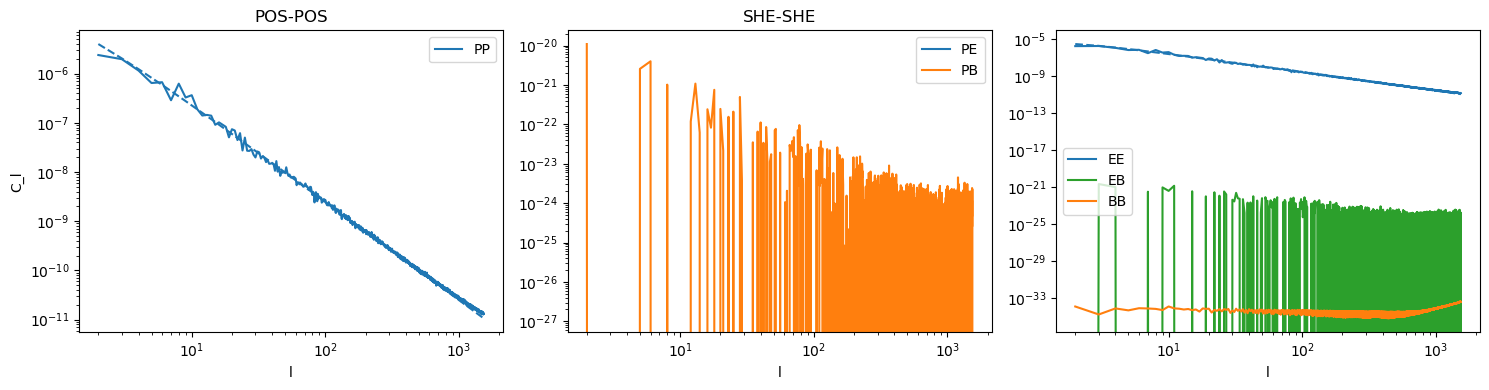

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
axs[0].plot(ell[2:], cls0[("POS", "POS", 1, 1)].array[2:], color="C0", label="PP")
axs[0].plot(ell[2:], theory[("POS", "POS", 1, 1)].array[2:], color="C0", linestyle="--")
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("l")
axs[0].set_ylabel("C_l")

# POS SHE
axs[1].plot(ell[2:], cls0[("POS", "SHE", 1, 1)].array[0][2:], color="C0", label="PE")
axs[1].plot(
    ell[2:], theory[("POS", "SHE", 1, 1)].array[0][2:], color="C0", linestyle="--"
)
axs[1].plot(ell[2:], cls0[("POS", "SHE", 1, 1)].array[1][2:], color="C1", label="PB")
axs[1].plot(
    ell[2:], theory[("POS", "SHE", 1, 1)].array[1][2:], color="C1", linestyle="--"
)
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("l")

# SHE SHE
axs[2].plot(ell[2:], cls0[("SHE", "SHE", 1, 1)].array[0, 0][2:], color="C0", label="EE")
axs[2].plot(
    ell[2:], theory[("SHE", "SHE", 1, 1)].array[0, 0][2:], color="C0", linestyle="--"
)
axs[2].plot(ell[2:], cls0[("SHE", "SHE", 1, 1)].array[0, 1][2:], color="C2", label="EB")
axs[2].plot(
    ell[2:], theory[("SHE", "SHE", 1, 1)].array[0, 1][2:], color="C2", linestyle="--"
)
axs[2].plot(ell[2:], cls0[("SHE", "SHE", 1, 1)].array[1, 1][2:], color="C1", label="BB")
axs[2].plot(
    ell[2:], theory[("SHE", "SHE", 1, 1)].array[1, 1][2:], color="C1", linestyle="--"
)
axs[2].legend()
axs[1].set_title("SHE-SHE")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()

## Jackknife Covariance

Now we will use `heracles` to compute the Jacknife covariance for the measured angular power spectra.
In order to do so we will use healpy to generate a segmentation map with the desired number of jackknife regions. 
Then we will use `heracles` to compute the Jackknife covariance from the segmentation map.

In [11]:
nside_seg = 2
n = 12 * nside_seg**2
print("number of jackknife regions:", n)

number of jackknife regions: 48


In [12]:
jk_map = hp.ang2pix(nside_seg, *hp.pix2ang(nside, np.arange(12 * nside**2)))
jk_maps = {}
for key in list(vis_maps.keys()):
    jk_maps[key] = 1 + jk_map

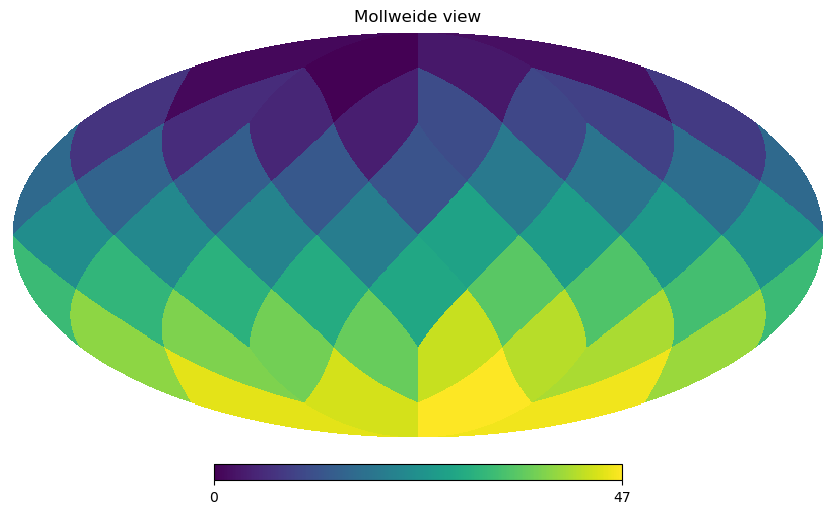

In [13]:
hp.mollview(jk_map)

In [14]:
cls1 = dices.jackknife_cls(data_maps, vis_maps, jk_maps, fields, nd=1)

In [15]:
cov_jk = dices.jackknife_covariance(cls1)

In [16]:
# Bin the Jackknife covariance
cov_jk_qq = heracles.binned(cov_jk, ledges)

/tmp/ipykernel_51496/3870193969.py:3: RuntimeWarning: invalid value encountered in divide
  flat_corr_jk = flat_cov_jk / np.sqrt(


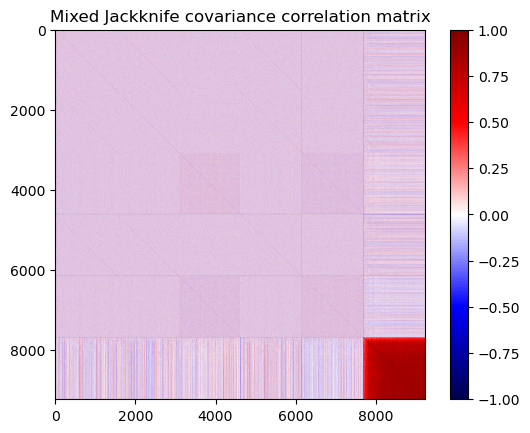

In [17]:
# Flattened cov_jk
flat_cov_jk = dices.flatten(cov_jk)
flat_corr_jk = flat_cov_jk / np.sqrt(
    np.diag(flat_cov_jk)[:, None] * np.diag(flat_cov_jk)[None, :]
)
plt.imshow(flat_corr_jk, cmap="seismic", vmin=-1, vmax=1)
plt.title("Mixed Jackknife covariance correlation matrix")
plt.colorbar()
plt.show()

In [18]:
# We will need this to bin the Guassian covariance
bmat = np.empty((len(ledges) - 1, lmax + 1))
_w = 2 * ell + 1
for i, (l1, l2) in enumerate(zip(ledges, ledges[1:])):
    _bin = (ell >= l1) & (ell < l2)
    bmat[i] = _bin * _w / _w[_bin].sum()

var(PP) relative difference:  0.3990408742070356
var(PE) relative difference:  0.18752706701581992
var(EE) relative difference:  0.14779972552743387


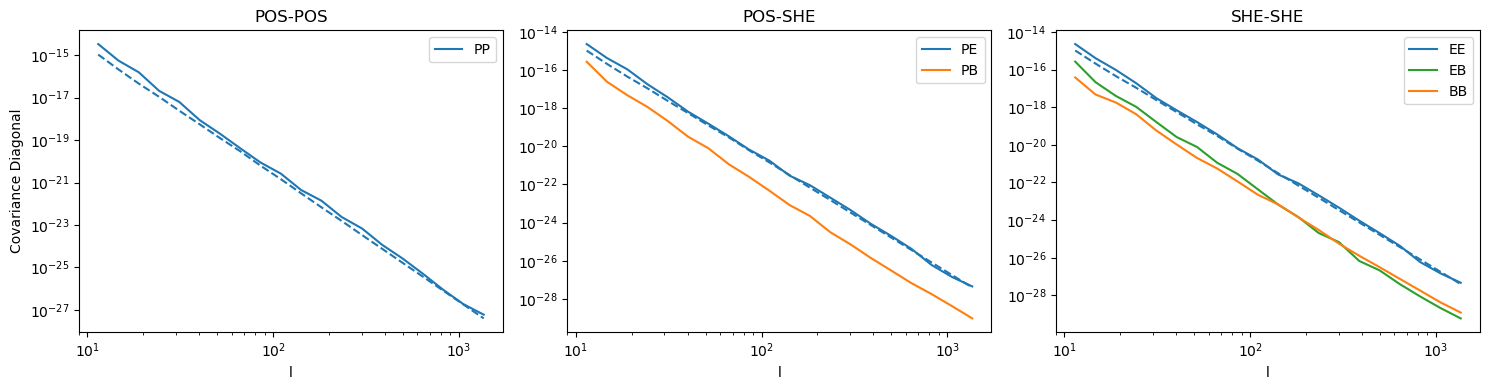

In [19]:
# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
c = cov_jk_qq[("POS", "POS", "POS", "POS", 1, 1, 1, 1)]
_c = np.diag(c)
__c = (
    bmat @ np.diag(2 * theory[("POS", "POS", 1, 1)].array ** 2 / (2 * ell + 1)) @ bmat.T
)
__c = np.diag(__c)

print("var(PP) relative difference: ", np.mean((_c - __c) / _c))
axs[0].plot(lgrid, _c, color="C0", label="PP")
axs[0].plot(lgrid, __c, color="C0", linestyle="--")
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("l")
axs[0].set_ylabel("Covariance Diagonal")

# POS SHE
c = cov_jk_qq[("POS", "SHE", "POS", "SHE", 1, 1, 1, 1)]
_c = np.diag(c[0, 0])
__c = (
    theory["POS", "SHE", 1, 1].array[0] ** 2
    + theory["POS", "POS", 1, 1].array * theory["SHE", "SHE", 1, 1].array[0, 0]
) / (2 * ell + 1)
__c = bmat @ np.diag(__c) @ bmat.T
__c = np.diag(__c)
print("var(PE) relative difference: ", np.mean((_c - __c) / _c))
axs[1].plot(lgrid, _c, color="C0", label="PE")
axs[1].plot(lgrid, __c, color="C0", linestyle="--")
_c = np.diag(c[1, 1])
__c = (
    theory["POS", "SHE", 1, 1].array[1] ** 2
    + theory["POS", "POS", 1, 1].array * theory["SHE", "SHE", 1, 1].array[1, 1]
) / (2 * ell + 1)
__c = bmat @ np.diag(__c) @ bmat.T
__c = np.diag(__c)
axs[1].plot(lgrid, _c, color="C1", label="PB")
axs[1].plot(lgrid, __c, color="C1", linestyle="--")
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("l")

# SHE SHE
c = cov_jk_qq[("SHE", "SHE", "SHE", "SHE", 1, 1, 1, 1)]
_c = np.diag(c[0, 0, 0, 0])
__c = 2 * theory[("SHE", "SHE", 1, 1)].array[0, 0] ** 2 / (2 * ell + 1)
__c = bmat @ np.diag(__c) @ bmat.T
__c = np.diag(__c)
print("var(EE) relative difference: ", np.mean((_c[2:] - __c[2:]) / _c[2:]))
axs[2].plot(lgrid, _c, color="C0", label="EE")
axs[2].plot(lgrid, __c, color="C0", linestyle="--")
_c = np.diag(c[0, 1, 0, 1])
__c = 2 * theory[("SHE", "SHE", 1, 1)].array[0, 1] ** 2 / (2 * ell + 1)
__c = bmat @ np.diag(__c) @ bmat.T
__c = np.diag(__c)
axs[2].plot(lgrid, _c, color="C2", label="EB")
axs[2].plot(lgrid, __c, color="C2", linestyle="--")
_c = np.diag(c[1, 1, 1, 1])
__c = 2 * theory[("SHE", "SHE", 1, 1)].array[1, 1] ** 2 / (2 * ell + 1)
__c = bmat @ np.diag(__c) @ bmat.T
__c = np.diag(__c)
axs[2].plot(lgrid, _c, color="C1", label="BB")
axs[2].plot(lgrid, __c, color="C1", linestyle="--")

axs[2].legend()
axs[2].set_title("SHE-SHE")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()